# ‚ùÑÔ∏è Analyse av v√¶rdata med Frost API
I denne notebooken gjennomf√∏res en analyse av historiske v√¶rdata fra Frost API, levert av Meteorologisk institutt (MET Norge). Gjennom √• hente inn, rense og analysere slike data kan vi f√• innsikt i klimaendringer og deres mulige milj√∏p√•virkninger.

Notebooken dokumenterer hele arbeidsflyten for Frost-delen av prosjektet - fra datainnhenting via API-et, til klargj√∏ring og analyse av de rensende dataene. Helt til slutt gjennomf√∏res en prediksjon p√• bakgrunn av den innhentede dataen.

### Datakilde: Frost API

**Kilde**: [frost.met.no](https://frost.met.no/)  
**Leverand√∏r**: Meteorologisk institutt  
**Datakvalitet**: H√∏y ‚Äì dataene er levert av en offentlig, autoritativ kilde  
**Tilgjengelighet**: √Öpen (krever gratis API-n√∏kkel)  
**Brukervennlighet**: God, med velstrukturert dokumentasjon og REST-endepunkter  

Valget av Frost API er basert p√• f√∏lgende kriterier:

- Kildeautoritet: Norsk Meteorologisk institutt er en nasjonal myndighet.
- Datakvalitet: Sanntidsdata og historiske data av h√∏y presisjon.
- Tilgjengelighet: √Öpent tilgjengelig for forsknings- og analyseform√•l.
- Brukervennlighet: API-et har god dokumentasjon og st√∏tter JSON-format.





### ‚òÅÔ∏è Henting og prosessering av v√¶rdata (Frost API)

F√∏rst henter vi v√¶rdata fra **Frost API**, som tilbys av Meteorologisk institutt. Dataene struktureres og lagres i et egnet format for videre analyse knyttet til klima- og milj√∏trender. 


#### Funksjonalitet

1. **Henting av v√¶rdata**:
   - Variabler: Temperatur, nedb√∏r og vindhastighet 
   - Stasjon: Oslo - SN18700
   - Periode: 2010-04-01 til 2016-12-30
   - Endepunkt: `https://frost.met.no/observations/v0.jsonld`

2. **Henting av hjelpedata**:
   - Tilgjengelige elementer (`/elements`)
   - Tilgjengelige stasjoner (`/sources`)

3. **Prosessering av data**:
   - Bearbeiding av JSON-respons til strukturert form
   - Filtrering og beregning av daglige verdier:
     - `mean(air_temperature P1D)`
     - `sum(precipitation_amount P1D)`
     - `mean(wind_speed P1D)`

4. **Lagring av data**:
   - Mappe: `../../data/raw_data/`
   - Filnavn: `frostAPI_data.json`

#### Viktige funksjoner

| Funksjon | Beskrivelse |
|---------|-------------|
| `data_frostAPI()` | Koordinerer hele hente- og lagringsprosessen |
| `fetch_weather_data_frostAPI()` | Kaller Frost API, prosesserer og lagrer v√¶rdata |
| `get_info_frostAPI()` | Brukes for √• inspisere hvilke elementer og stasjoner som er tilgjengelige |

#### Forutsetninger

- Gyldig API-n√∏kkel fra [Frost API](https://frost.met.no/)
- Python installert med n√∏dvendige pakker: `requests`, `pandas`, `json`, `os`, `pandasql`
- Skrivetilgang til lokal mappe for data: `../../data/raw_data/`


In [37]:
#Importerte biblioteker
import os
import sys
import pandas as pd
import pandasql as psql
from pandasql import sqldf
from dotenv import load_dotenv
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import json



#Globale parametrere for frostAPI
load_dotenv()
client_id = os.getenv('client_id_frost') #henter unik id fra .env fil
from_date = "2010-04-02"
to_date = "2016-12-30"

#Filbane til data
sys.path.insert(0, '../../src/')


In [38]:
# Henter tilgjenglige elementer
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import get_elements_frostAPI
get_elements_frostAPI(client_id)

ID: accumulated(liquid_water_content_of_surface_snow), Navn: Total snow water equivalent
ID: accumulated(precipitation_amount), Navn: Precipitation in gauge
ID: air_pressure, Navn: Air pressure as measured at sensor height
ID: air_pressure_at_sea_level, Navn: Air pressure at sea level
ID: air_pressure_at_sea_level_qnh, Navn: Air pressure (QNH)
ID: air_temperature, Navn: Air temperature
ID: air_temperature_vertical_difference, Navn: Air temperature -vertical diff
ID: altitude, Navn: Altitude
ID: automatic_metar, Navn: Automatic METAR
ID: barometer_temperature, Navn: Temperature of (mercury) barometer
ID: battery_voltage, Navn: Battery voltage
ID: beaufort_wind_force, Navn: Wind force in Beaufort
ID: best_estimate_max(air_temperature P1D), Navn: Homogenised maximum air temperature (24 h)
ID: best_estimate_mean(air_temperature P1D), Navn: Homogenised mean temperature (24 h)
ID: best_estimate_mean(air_temperature P1M), Navn: Homogenised mean temperature (month)
ID: best_estimate_mean(air_t

In [39]:
# Henter tilgjenglige stasjoner med ID
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import get_stations_frostAPI
get_stations_frostAPI(client_id)

ID: SN47230, Navn: √ÖKRA UNGDOMSSKOLE
ID: SN20952, Navn: STATFJORD C
ID: SN23670, Navn: E16 RYFOSS
ID: SN59450, Navn: STADLANDET
ID: SN55000, Navn: LUSTER - ORNES
ID: SN12590, Navn: E6 MJ√òSBRUA
ID: SN26640, Navn: E134 DARBU
ID: SN67650, Navn: FV30 REITST√òA
ID: SN18269, Navn: OSLO - HAUGENSTUA
ID: SN68090, Navn: TRONDHEIM - GRAN√ÖSEN
ID: SN57790, Navn: MYKLEBUSTFJELLET
ID: SN27860, Navn: KVELDE
ID: SN61065, Navn: E136 TRESFJORDBRUA
ID: SN18700, Navn: OSLO - BLINDERN
ID: SN27600, Navn: SANDEFJORD
ID: SN87110, Navn: AND√òYA
ID: SN40250, Navn: VALLE
ID: SN40905, Navn: RV9 BJ√ÖEN
ID: SN27295, Navn: FV307 GRAVDAL
ID: SN43220, Navn: FV44 S√ÜLEB√ò
ID: SN19660, Navn: E16 SKUI
ID: SN18260, Navn: OSLO - H√òYBR√ÖTEN
ID: SN49240, Navn: RV13 L√ÖTEFOSS
ID: SN77295, Navn: SVENNINGDAL
ID: SN52990, Navn: ORTNEVIK
ID: SN5350, Navn: NORD-ODAL
ID: SN76963, Navn: KRISTINFELTET
ID: SN92170, Navn: OKSFJORD
ID: SN90295, Navn: SESS√òYA
ID: SN80740, Navn: REIP√Ö
ID: SN490381002, Navn: 300 KV SAUDA ‚Äì BL√ÖFALL

In [40]:
# Grupperer og lagrer √∏nsket data fra frostAPI
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import data_frostAPI
data_frostAPI(client_id)

Gruppert data er lagret under ../../data/raw_data/frostAPI_data.json


### üßπ Rensing og klargj√∏ring av Frost-data

Videre fokuserer vi p√• rensing og forberedelse av v√¶rdata hentet fra **Frost API**. M√•let er √• sikre at dataene er konsistente og egnet for videre analyse ved √• identifisere og h√•ndtere ekstreme verdier og manglende m√•linger.

#### Funksjonalitet

##### 1. Visualisering og identifisering av outliers

- Bruker `Pandas` til √• beregne:
  - Gjennomsnitt
  - Standardavvik
  - √òvre og nedre grense for avvik (¬±3 std)
- Plotter distribusjon for hver variabel (`Nedb√∏r`, `Temperatur`, `Vindhastighet`) med `Seaborn` og `Matplotlib`.
- Markerer uteliggere med r√∏de linjer i plottet.

##### 2. Fjerning og interpolering

- Verdier utenfor grenseverdiene erstattes med `NaN`.
- Manglende og fjernede verdier interpoleres for √• sikre kontinuitet.
- Resultatet lagres som en ny JSON-fil for videre analyse.

#### Viktige funksjoner

##### `clean_data_frostAPI()`

| Funksjon                | Beskrivelse                                                       |
|------------------------|------------------------------------------------------------------|
| **Laster inn r√•data**    | Leser r√•data fra `frostAPI_data.json`.                           |
| **Fjerner outliers**     | Kaller `remove_outliers_frost_data` for √• identifisere og sette outliers til `NaN`. |
| **Interpolerer manglende verdier** | Bruker `interpolate_and_save_clean_data` for √• fylle inn manglende verdier. |
| **Lagrer renset data**  | Lagres som `frostAPI_clean_data.json`.                           |


#### Forutsetninger

- R√•data m√• v√¶re tilgjengelig i: `../../data/raw_data/frostAPI_data.json`
- Python-moduler fra prosjektmappen m√• v√¶re importert:
  - `clean_data_frostAPI()`
- Krever `Pandas`, `Seaborn`, `Matplotlib`, og `sys` for kj√∏ring.
- Resultatene lagres i: `../../data/clean_data/frostAPI_clean_data.json`



Outliers for Nedb√∏r:
Nedb√∏r    62
dtype: int64


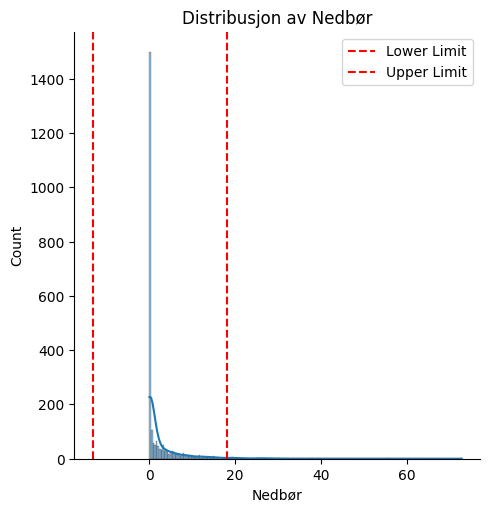


Outliers for Temperatur:
Temperatur    0
dtype: int64


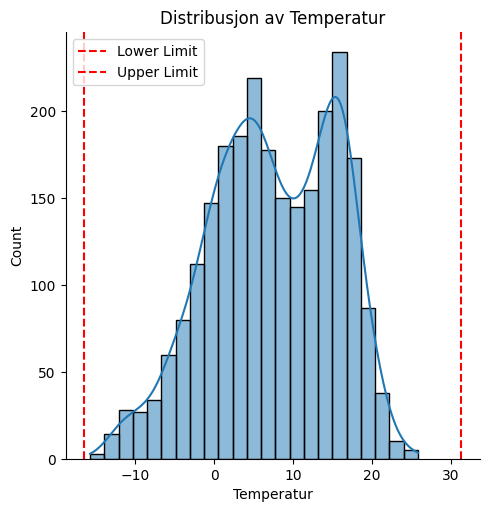


Outliers for Vindhastighet:
Vindhastighet    25
dtype: int64


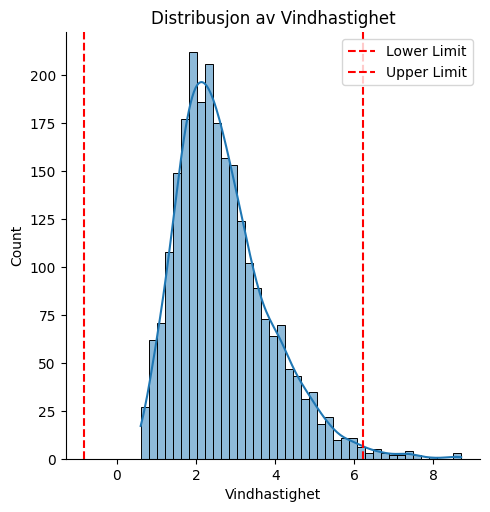

In [41]:
# Analyserer og visualiserer outliers i dataene
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import analyze_frost_data
analyze_frost_data()

In [42]:
# Leser r√•data, fjerner outliers, interpolerer manglende verdier og lagrer i clean_data
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import clean_data_frostAPI
clean_data_frostAPI()


Fjerning av outliers:
Outliers er mer enn 3 standardavvik unna gjennomsnittet

Nedb√∏r:
Fjernet 62 outliers
Standardavvik: 5.22
Gjennomsnitt: 2.43

Temperatur:
Fjernet 0 outliers
Standardavvik: 7.95
Gjennomsnitt: 7.43

Vindhastighet:
Fjernet 25 outliers
Standardavvik: 1.18
Gjennomsnitt: 2.71


Interpolering av NaN-verdier:
Nedb√∏r: 63 verdier ble interpolert
Temperatur: 1 verdier ble interpolert
Vindhastighet: 27 verdier ble interpolert

Gruppert data er lagret under ../../data/clean_data/frostAPI_clean_data.json


## ‚öñÔ∏è Korrigering av skjevhet i v√¶rdata

Videre transformerer vi v√¶rdata fra Frost API ved √• korrigere for skjevhet i fordelingene (ved hjelp av Yeo-Johnson-transformasjon og/eller standardisering). Dette gj√∏r dataene mer symmetriske og bedre egnet for videre analyse og maskinl√¶ring.

#### Funksjonalitet
##### 1. Analyse og korrigering av skjevhet
- Leser inn renset v√¶rdata fra frostAPI_clean_data.json.
- Bruker Pandas til √• beregne skjevhet (skew()) for hver valgt kolonne.
- Identifiserer kolonner der skjevheten er h√∏yere enn terskelen (¬±1.0).
- Anvender f√∏lgende transformasjoner:
    - **Yeo-Johnson + standardisering** for sterkt skjeve kolonner.
    - **Kun standardisering** for mindre skjeve kolonner.
- Skriver ut skjevhet f√∏r og etter transformasjon i konsollen.

##### 2. Lagring av transformerte data
- Resultatet lagres som frostAPI_analyzed_data.json i mappen analyzed_data.
- Filen inneholder de samme kolonnene, men med transformerte og skalerte verdier.
- Dataene er n√• egnet for videre analyse og maskinl√¶ring.

#### Viktige funksjoner
`fix_skewness_data_frostAPI()`

| Funksjon                | Beskrivelse                                                       |
|------------------------|------------------------------------------------------------------|
| **Laster inn rensede data**    | Leser renset data fra `frostAPI_clean_data.json`.                           |
| **Analyserer skjevhet**     | `analyse_and_fix_skewness() beregner skjevhet og avgj√∏r transformasjonsmetode. |
| **Transformerer fordelinger og standardiserer data** | Bruker Yeo-johnson og standardisering ved h√∏y skjevhet. Kolonner med lav skjevhet standardiseres direkte. |
| **Lagrer transformerte data**  | Lagres som `frostAPI_analyzed_data.json`.                           |


#### Forutsetninger

- Renset data m√• v√¶re tilgjengelig i: `../../data/clean_data/frostAPI_clean_data.json`
- Python-moduler fra prosjektmappen m√• v√¶re importert:
  - `fix_skewness_data_frostAPI()`
- Krever `Pandas`, `Numpy` og `sys` for kj√∏ring.
- Resultatene lagres i: `../../data/analyzed_data/frostAPI_analyzed_data.json`


In [43]:
# Analyserer og korrigerer skjevhet i dataene og lagrer analyserte data
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import fix_skewness_data_frostAPI
fix_skewness_data_frostAPI()


<function frostAPI.data_frostAPI.fix_skewness_data_frostAPI()>

## üìä Analyse av v√¶rdata fra Frost API (2010-2016)

I denne delen analyserer vi historiske v√¶rdata for Oslo over en seks√•rsperiode (2010‚Äì2016), innhentet via Frost API gjennom tidligere steg i prosjektet. Form√•let er √• identifisere m√∏nstre og trender i temperatur, nedb√∏r og vindhastighet for √• f√• innsikt i mulige klimatiske endringer over tid.

#### Metoder brukt for analyse:
- **PandasSQL** - gir fleksibel og effektiv datafiltrering, gruppering og aggregering 
- ... mer
- ... mer

#### Analysestruktur:
- **Topp 10 varmeste dager** ‚Äì hvilke dager hadde de h√∏yeste temperaturene, og hva kjennetegner disse dagene med tanke p√• nedb√∏r og vind, og hvilke √•r forekom de oftest?
- **Topp 10 kaldeste dager** ‚Äì hvilke dager hadde de laveste temperaturene, og hvilke √•r forekom de oftest?
- **√Örlig gjennomsnittstemperatur** ‚Äì ser vi en synkende, stigende eller stabil trend over seks√•rsperioden?
- **Ukentlige v√¶rtrender** ‚Äì hvordan varierer temperatur, nedb√∏r og vindhastighet gjennom √•ret?
- **Standardavvik** - hvor mye varierer verdiene i datasettet fra gjennomsnittet?

Alle analyser er st√∏ttet av visualiseringer og forklares med observasjoner og tolkninger. Dataene er renset og strukturert p√• forh√•nd for √• sikre n√∏yaktighet og sammenlignbarhet.

### Analyse av topp 10 dager med h√∏yest temperatur 

*Resultatet viser de ti varmeste dagene i Oslo over 6 √•r (2010-2016) hvor dataen er hentet fra frostAPI.*

**Observasjoner:**
- Sommeren 2014 var ekstremt varm: hele 9 av 10 varmeste dager forekom i juli 2014. 
- Lav nedb√∏r: 6/10 dager hadde 0 mm nedb√∏r, noe som ofte gir sterk soloppvarming (samsvarer alts√• med den h√∏ye temperaturen).
- Moderat vind: De fleste dagene hadde vindhastigheter p√• rundt 2 m/s.

**Tolkning:**
Analysen tyder p√• at 2014 var et unormalt varmt √•r i Oslo, spesielt i juli. Det h√∏ye antallet ekstremt varme dager p√• rad kan tyde p√• en varmeb√∏lge, som er et fenomen ofte knyttet til klimaendringer og √∏kt global temperatur.

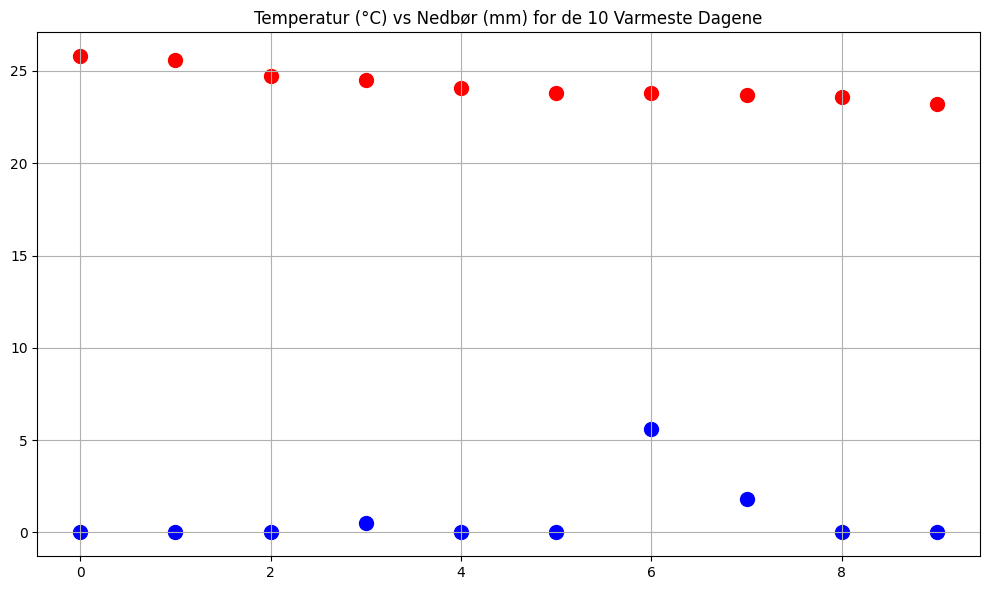

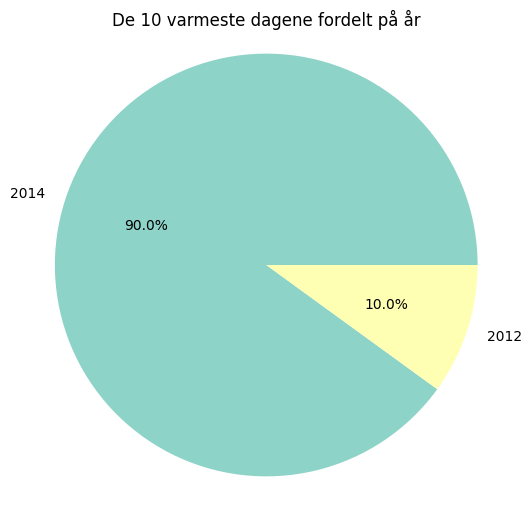

Dato  Nedb√∏r  Temperatur  Vindhastighet  Interpolert_Nedb√∏r  \
0  2014-07-24     0.0        25.8            1.9                   0   
1  2014-07-26     0.0        25.6            2.0                   0   
2  2014-07-10     0.0        24.7            2.1                   0   
3  2014-07-25     0.5        24.5            1.7                   0   
4  2014-07-22     0.0        24.1            2.0                   0   
5  2012-05-26     0.0        23.8            4.0                   0   
6  2014-07-27     5.6        23.8            1.8                   0   
7  2014-07-23     1.8        23.7            1.9                   0   
8  2014-07-11     0.0        23.6            1.9                   0   
9  2014-07-12     0.0        23.2            2.0                   0   

   Interpolert_Temperatur  Interpolert_Vindhastighet    √Ör  
0                       0                          0  2014  
1                       0                          0  2014  
2                       0                          0  2014  
3                       0                          0  2014  
4                       0                          0  2014  
5                       0                          0  2012  
6                       0                          0  2014  
7                       0                          0  2014  
8                       0                          0  2014  
9                       0                          0  2014

In [44]:
# Henter ut og visualiserer de 10 varmeste dagene i datasettet 
#samt setter de i sammenheng med mengde nedb√∏r
sys.path.insert(0, '../../src')
from sql_analysis import analyze_frost_api_clean_data
analyze_frost_api_clean_data()

### Analyse av topp 10 dager med lavest temperatur

*Resultatet viser de ti kaldeste dagene i Oslo over 6 √•r (2010-2016) hvor dataen er hentet fra frostAPI.*

**Observasjoner:**
- Fire av de 10 kaldeste dagene stammer fra 2010, noe som indikerer en spesielt kald vinter dette √•ret.
- 9/10 av de kaldeste dagene forekom f√∏r 2014.

**Tolkning:**
Dataene fra 2010 til 2016 viser at ekstrme kuldedager forekom relativt hyppig i starten av perioden. Etter 2013 avtar dog antall ekstremt kalde dager, og den siste kuldedagen i listen er fra 2016. Dette kan tyde p√• en tendens mot mildere vintre, og indikere et gradvis varmere klima. 

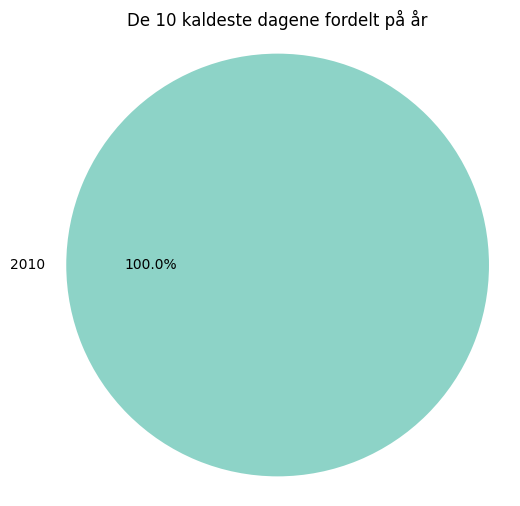

Dato Temperatur    √Ör
0  2010-01-01       None  2010
1  2010-01-02       None  2010
2  2010-01-03       None  2010
3  2010-01-04       None  2010
4  2010-01-05       None  2010
5  2010-01-06       None  2010
6  2010-01-07       None  2010
7  2010-01-08       None  2010
8  2010-01-09       None  2010
9  2010-01-10       None  2010

In [45]:
# Henter ut og visualiserer de 10 kaldeste dagene i datasettet
sys.path.insert(0, '../../src')
from sql_analysis import analyze_coldest_frost_api_data
analyze_coldest_frost_api_data()

### Analyse av gjennomsnittlig temperatur per √•r 

*Resultatet viser gjennnomsnittstemperaturen per √•r i Oslo over 6 √•r (2010-2016) hvor dataen er hentet fra frostAPI.*

**Generell trend:**
Gjennomsnittstemperaturen per √•r i Oslo ser ut til √• ha holdt seg relatvit stabilt de siste √•rene (et stabilt resultat p√• mellom 6 og 9 grader celcius). Dette kan indikere et relativt stabilit klima uten en klar stigende eller synkende trend over disse √•rene. 

**Avvik:**
Data for 2010 inkluderer bare perioden fra 1. april og ut √•ret, noe som kan gj√∏re temperaturen h√∏yere enn normalt √•rsgrunnlag siden vinterm√•nedene mangler.

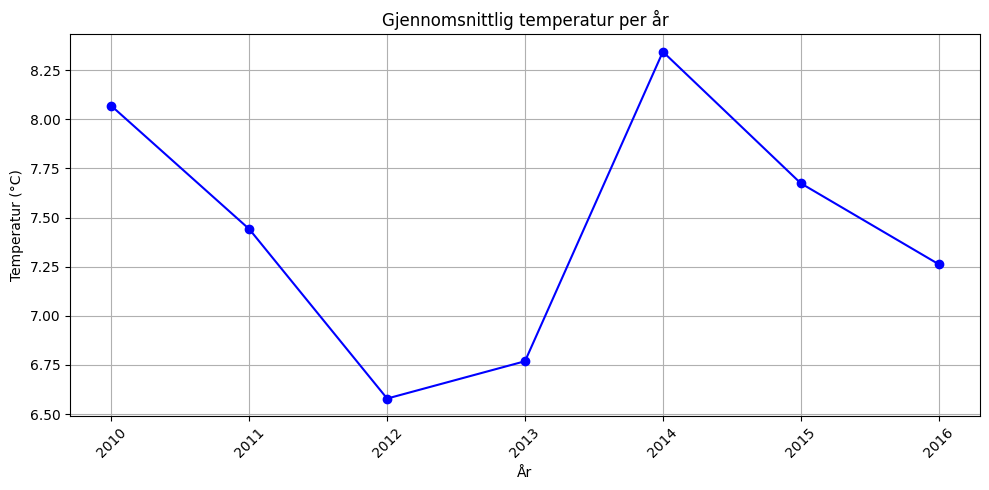

√Ör  Gjennomsnitt_temperatur
0  2010                 8.068613
1  2011                 7.441370
2  2012                 6.578689
3  2013                 6.768767
4  2014                 8.344384
5  2015                 7.674795
6  2016                 7.262842

In [46]:
# Henter ut og visualiserer gjennomsnittlig temperatur per √•r 
from sql_analysis import analyze_avg_temp_frost_api_data
analyze_avg_temp_frost_api_data()

### Gjennomsnittlig nedb√∏r, temperatur og vindhastighet per uke 

*Viser gjennomsnittlig nedb√∏r, temperatur og vindhastighet per uke i Oslo fra 2010-2016.*


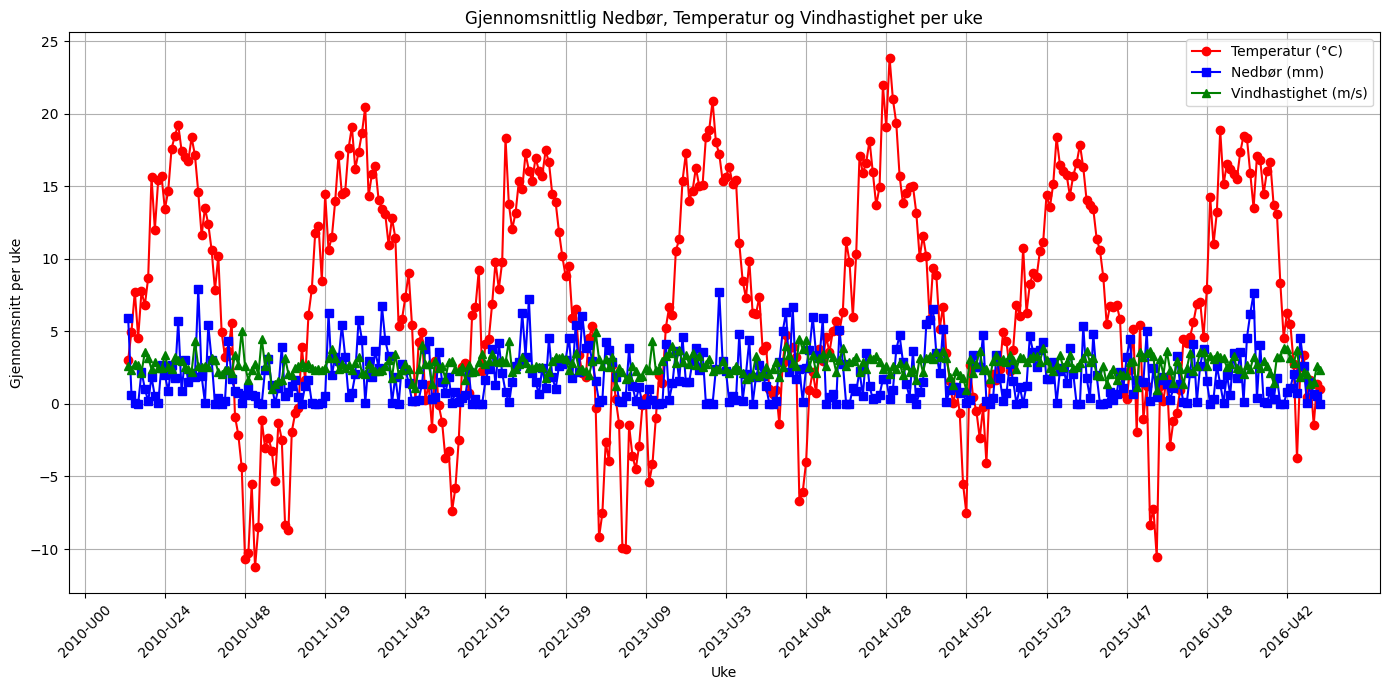

Uke  Avg_Nedb√∏r  Avg_Temperatur  Avg_Vindhastighet
0    2010-U00         NaN             NaN                NaN
1    2010-U01         NaN             NaN                NaN
2    2010-U02         NaN             NaN                NaN
3    2010-U03         NaN             NaN                NaN
4    2010-U04         NaN             NaN                NaN
..        ...         ...             ...                ...
366  2016-U48    0.028571        0.500000           2.028571
367  2016-U49    1.514286        1.657143           1.357143
368  2016-U50    0.671429       -1.428571           1.485714
369  2016-U51    0.571429        1.385714           2.642857
370  2016-U52    0.000000        1.014286           2.357143

[371 rows x 4 columns]

In [47]:
# Henter ut og visualiserer gjennomsnittlig nedb√∏r, temperatur og vindhastighet per uke
from sql_analysis import analyze_weekly_avg_frost_api_data
analyze_weekly_avg_frost_api_data()

### Variasjon i v√¶rdata: Standardvik for nedb√∏r, temperatur og vindhastighet

*Regner standardavviket til hele datasettet og standardavvik per uke (frostAPI) for nedb√∏r, temperatur og vindhastighet.*

Standardavvik gir en indikasjon p√• hvor mye variasjon det er i v√¶rdataen.

In [48]:
# Henter ut standardavviket for nedb√∏r, temperatur og vindhastighet for hele datasettet
from sql_analysis import calculate_std_frost_data
calculate_std_frost_data()

StdDev_Nedb√∏r  StdDev_Temperatur  StdDev_Vindhastighet
0       3.509403           7.947256              1.102797

In [49]:
# Henter ut standardavviket for nedb√∏r, temperatur og vindhastighet per uke
from sql_analysis import calculate_std_frost_weekly
calculate_std_frost_weekly()  

Uke  StdDev_Nedb√∏r  StdDev_Temperatur  StdDev_Vindhastighet
0    2010-U00            NaN                NaN                   NaN
1    2010-U01            NaN                NaN                   NaN
2    2010-U02            NaN                NaN                   NaN
3    2010-U03            NaN                NaN                   NaN
4    2010-U04            NaN                NaN                   NaN
..        ...            ...                ...                   ...
366  2016-U48       2.016178           7.891209              1.387821
367  2016-U49       3.897375           6.821157              1.492694
368  2016-U50       2.009765           9.803375              1.511096
369  2016-U51       1.707648           6.954792              1.296485
370  2016-U52       2.045621           7.268949              1.231036

[371 rows x 4 columns]